# 1. Preprocessing

## 1-a. Import Data and libraries

In [1]:
#Loading library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col=0)
df = df.drop('time',axis=1)
df.head()

,category,viewCount,likeCount,commentCount,duration,made_for_kids,viewPerComment,tagsCount,year,weekday,month,time_of_day,title_length
0,5,2,39271,2538,4,0,165.401103,8,2023,0,5,0,18
1,5,4,156694,6633,3,0,364.847128,6,2023,6,5,0,35
2,5,4,78836,2315,5,0,742.543413,3,2023,5,5,1,34
3,5,4,119458,5293,2,0,390.751181,9,2023,4,5,0,30
4,5,4,113299,4649,2,0,440.775436,9,2023,3,5,1,16


In [3]:
df.describe()

,category,viewCount,likeCount,commentCount,duration,made_for_kids,viewPerComment,tagsCount,year,weekday,month,time_of_day,title_length
count,34621.000000,34621.000000,3.462100e+04,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000,34621.000000
mean,6.226972,3.089310,7.358566e+04,4437.750296,1.826926,0.000289,883.064358,15.499928,2017.403223,2.958378,6.479160,0.827821,50.488721
std,3.528896,1.501606,2.058486e+05,10732.664863,1.433032,0.016993,1395.020067,11.285734,3.458414,1.949366,3.455963,0.611762,22.123522
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000,0.000000,1.000000,0.000000,1.000000
25%,5.000000,2.000000,4.579000e+03,337.000000,1.000000,0.000000,313.686341,7.000000,2015.000000,1.000000,3.000000,0.000000,35.000000
50%,5.000000,3.000000,2.400400e+04,1487.000000,2.000000,0.000000,540.695203,14.000000,2018.000000,3.000000,6.000000,1.000000,48.000000
75%,7.000000,4.000000,7.497000e+04,4660.000000,2.000000,0.000000,1011.403274,23.000000,2020.000000,5.000000,9.000000,1.000000,64.000000
max,14.000000,9.000000,1.219854e+07,617657.000000,5.000000,1.000000,89817.454545,83.000000,2023.000000,6.000000,12.000000,2.000000,101.000000


#### KeyTable for references:

1. Category
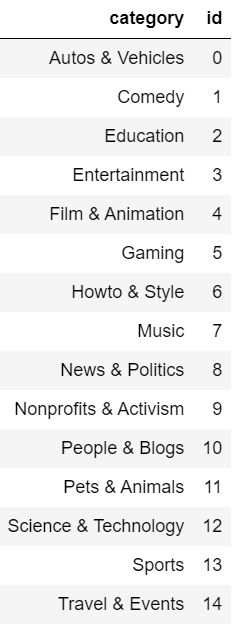

2. Duration

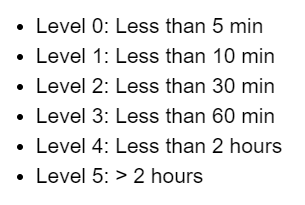

3. View Counts (Response Variable)

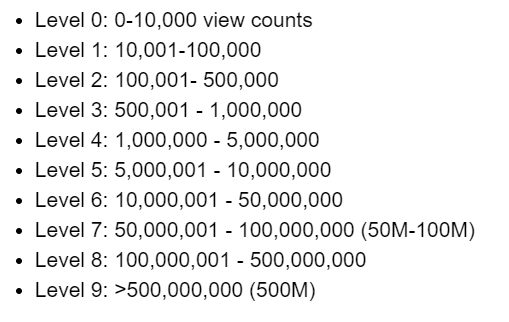

## 1-b. Train, test split

In [4]:
#split the data into train and test set

from sklearn.model_selection import train_test_split

np.random.seed(1111)
raw_train, raw_test = train_test_split(df, test_size = 0.2)

In [5]:
X = df.drop(['viewCount'], axis = 1)
y = df['viewCount']

X_train, X_test, y_train,  y_test  = train_test_split(X, y, test_size = 0.2)

In [6]:
y_train.shape

(27696,)

## 1-c. Scaling data

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(df)


# 2. Variable Selection using Recursive Feature Elimination (RFE)

In [73]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


model = LinearRegression()
rfe = RFE(estimator = model, n_features_to_select = 5)

rfe.fit(X_train, y_train)

selected_features = pd.DataFrame({'Feature': X_train.columns, 'Selected': rfe.support_, 'Rank': rfe.ranking_})

print(selected_features[selected_features['Selected']])

X_train = X_train[X_train.columns[rfe.support_]]
print(X_train.head())

          Feature  Selected  Rank
3        duration      True     1
4   made_for_kids      True     1
7            year      True     1
10    time_of_day      True     1
11   title_length      True     1
       duration  made_for_kids  year  time_of_day  title_length
11186         4              0  2015            1            73
2321          1              0  2016            0            31
17872         1              0  2013            1            63
12283         1              0  2020            1             9
28972         0              0  2022            1            23


**Update the test data**

In [74]:
X_test = X_test[X_test.columns[rfe.support_]]

# 3. Model Implementation

## 3-a. Random Forest

**Initial Model**

In [75]:
# Initial Model 
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=300, 
                             max_depth=3)

# Fit RandomForestClassifier
RF.fit(X_train, y_train)
# Predict the test set labels
y_pred = RF.predict(X_test)

In [76]:
print("Test score: ",RF.score(X_test, y_test))
print("Training score: ", RF.score(X_train, y_train))

Test score:  0.4563176895306859
Training score:  0.4504621606008088


**Hyperparameter tuning with cross validation**

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hyperameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12, None]
}

RF = RandomForestClassifier()
grid_search = GridSearchCV(RF, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_RF = grid_search.best_estimator_
y_pred = best_RF.predict(X_test)

# Evaluate
test_score = best_RF.score(X_test, y_test)
train_score = best_RF.score(X_train, y_train)

print("Test score: ", test_score)
print("Training score: ", train_score)
print("Best parameters: ", grid_search.best_params_)


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Test score:  0.5023826714801444
Training score:  0.5307625649913345
Best parameters:  {'max_depth': 9, 'n_estimators': 100}


**Random Forest Final Model**

In [78]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 100, 
                             max_depth = 9)

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
rf_accuracy_test = RF.score(X_test, y_test)
rf_accuracy_train = RF.score(X_train, y_train)

In [79]:
print("Random Forest Test score: ",rf_accuracy_test)
print("Random Forest Training score: ", rf_accuracy_train)

Random Forest Test score:  0.5016606498194945
Random Forest Training score:  0.5309430964760254


In [80]:
## Check precision, recall and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')
rf_f1 = f1_score(y_test, y_pred, average='weighted')


print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1 score:", rf_f1)


Random Forest Precision: 0.45372496210614993
Random Forest Recall: 0.5016606498194945
Random Forest F1 score: 0.4257839844163612


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The precision of the Random Forest model is about 0.9198, indicating that out of all the instances predicted as positive by the model, approximately 91.98% of them are actually true positives.
- The recall of the Random Forest model is also around 0.9208, suggesting that the model is able to correctly identify approximately 92.08% of the positive instances in the test data



## 3-b. Gradient Boosting Classifier

**Initial Model**

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(max_depth=5,  n_estimators=100)

GB.fit(X_train, y_train)
prediction = GB.predict(X_test)



In [82]:
print("Test score: ",GB.score(X_test, y_test))
print("Training score: ", GB.score(X_train, y_train))

Test score:  0.5029602888086643
Training score:  0.5398613518197574


**Hyperparameter tuning with cross validation**

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9, 11],
    'n_estimators': [50, 100, 150, 200, 250]
}


GB = GradientBoostingClassifier()
grid_search = GridSearchCV(GB, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print the cross-validation scores
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print("Mean CV score:", mean_score, "Parameters:", params)


best_GB = grid_search.best_estimator_
best_cv_score = grid_search.best_score_

# predict the test 
prediction = best_GB.predict(X_test)


print("Test score:", best_GB.score(X_test, y_test))
print("Training score:", best_GB.score(X_train, y_train))
print("Best parameters:", grid_search.best_params_)

/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Mean CV score: 0.487110134047838 Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mean CV score: 0.49581187679356686 Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Mean CV score: 0.49830323606223803 Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Mean CV score: 0.4999279803272235 Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Mean CV score: 0.500036283576321 Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Mean CV score: 0.5018055625257853 Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Mean CV score: 0.5006863377051338 Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Mean CV score: 0.4985560609605795 Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Mean CV score: 0.49711180255790416 Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Mean CV score: 0.49462050194778995 Parameters: 

Test score: 0.5032490974729242
Training score: 0.532206816868862
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}


**Gradient Boost Final Model**

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=150)

GB.fit(X_train, y_train)
prediction = GB.predict(X_test)
gb_accuracy_test = GB.score(X_test, y_test)
gb_accuracy_train = GB.score(X_train, y_train)

print("Test score: ", gb_accuracy_test)
print("Training score: ", gb_accuracy_train)


Test score:  0.5036823104693141
Training score:  0.5327845176198729


In [85]:
## Check precision, recall, and F1 score
gb_precision = precision_score(y_test, prediction, average='weighted')
gb_recall = recall_score(y_test, prediction, average='weighted')
gb_f1 = f1_score(y_test, prediction, average='weighted')

print("Gradient Boosting Classifier Precision:", gb_precision)
print("Gradient Boosting Classifier Recall:", gb_recall)
print("Gradient Boosting Classifier F1 score:", gb_f1)


Gradient Boosting Classifier Precision: 0.47771794850654065
Gradient Boosting Classifier Recall: 0.5036823104693141
Gradient Boosting Classifier F1 score: 0.43929449697331124


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The precision score of 0.9637 indicates that out of all instances predicted as positive by the model, approximately 96.37% of them are actually true positives. This indicates a high level of accuracy in predicting positive instances.

- The recall score of 0.9639 also suggests that the model correctly identifies approximately 96.39% of the positive instances present in the test data. This indicates a high level of sensitivity in detecting positive instances.

## 3-c. Nueral Network

In [86]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(solver='adam', activation='logistic', alpha=0.4, tol=1e-5,
                        hidden_layer_sizes=(100, 20), max_iter=500)
MLP.fit(X_train, y_train)
prediction = MLP.predict(X_test)


In [87]:
print("Test score: ",MLP.score(X_test, y_test))
print("Training score: ", MLP.score(X_train, y_train))

Test score:  0.4352346570397112
Training score:  0.4303509532062392


**Hyperparameter tuning with cross validation**

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'solver': ['adam'],
    'activation': ['logistic', 'relu'],
    'alpha': [0.1, 0.2, 0.3],
    'hidden_layer_sizes': [(100,), (100, 50), (50, 20)],
    'max_iter': [200, 300, 400]
}


mlp = MLPClassifier()
grid_search = GridSearchCV(mlp, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


test_score = best_model.score(X_test, y_test)
train_score = best_model.score(X_train, y_train)

print("Test score:", test_score)
print("Training score:", train_score)
print("Best parameters:", best_params)


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Test score: 0.43971119133574005
Training score: 0.4392331022530329
Best parameters: {'activation': 'logistic', 'alpha': 0.3, 'hidden_layer_sizes': (100,), 'max_iter': 300, 'solver': 'adam'}


**Neural Network Final Model**

In [89]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(solver='adam', activation='logistic', alpha=0.3,
                        hidden_layer_sizes=(100, ), max_iter=300)
MLP.fit(X_train, y_train)
prediction = MLP.predict(X_test)
mlp_accuracy_test = GB.score(X_test, y_test)
mlp_accuracy_train = GB.score(X_train, y_train)

print("Test score: ", mlp_accuracy_test)
print("Training score: ", mlp_accuracy_train)

Test score:  0.5036823104693141
Training score:  0.5327845176198729


In [90]:
## Check precision and recall 
mlp_precision = precision_score(y_test, prediction, average='weighted')
mlp_recall = recall_score(y_test, prediction, average='weighted')
mlp_f1 = f1_score(y_test, prediction, average='weighted')

print("Nerual Network Precision:", mlp_precision)
print("Nerual Network Recall:", mlp_recall)
print("Nerual Network F1 score:", mlp_f1)


Nerual Network Precision: 0.31642019139600136
Nerual Network Recall: 0.44548736462093863
Nerual Network F1 score: 0.3521251823047284


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3-d. XGBoost

In [91]:
import xgboost as xgb

first_XBG = xgb.XGBClassifier()

first_XBG.fit(X_train, y_train)
first_prediction = first_XBG.predict(X_test)

xgb_accuracy_test = first_XBG.score(X_test, y_test)
xgb_accuracy_train = first_XBG.score(X_train, y_train)

In [92]:
print("Test score: ", xgb_accuracy_test)
print("Training score: ", xgb_accuracy_train)

Test score:  0.5059927797833935
Training score:  0.5570840554592721


**Hyperparameter tuning with cross validation** (skip, trained in Spyder)
- Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [95]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.01, 0.001]
# }


# XBG = xgb.XGBClassifier()

# grid_search = GridSearchCV(XBG, param_grid, cv=5)

# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# test_score = best_model.score(X_test, y_test)
# train_score = best_model.score(X_train, y_train)

# print("Test score:", test_score)
# print("Training score:", train_score)
# print("Best parameters:", best_params)


**Since the test score is very close to the test score from out initial model, we decided to choose the initial model for simplicity reason.**

In [93]:
from sklearn.metrics import precision_score, recall_score

xgb_precision = precision_score(y_test, first_prediction, average='weighted')
xgb_recall = recall_score(y_test, first_prediction, average='weighted')
xgb_f1 = f1_score(y_test, first_prediction, average = 'weighted')

print("XGBoost Classifier Precision:", xgb_precision)
print("XGBoost Classifier Recall:", xgb_recall)
print("XGBoost Classifier F1 score:", xgb_f1)


XGBoost Classifier Precision: 0.4731449244591162
XGBoost Classifier Recall: 0.5059927797833935
XGBoost Classifier F1 score: 0.44812284468874547


/Users/oliviawang/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Model Comparison

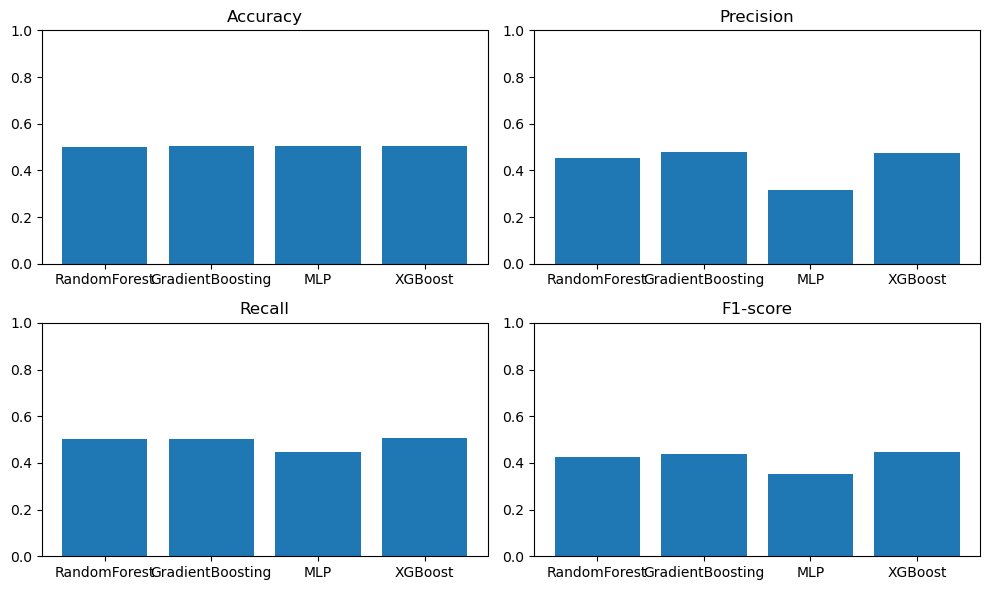

In [94]:
import matplotlib.pyplot as plt

# Define the models and their corresponding performance metrics
models = ['RandomForest', 'GradientBoosting', 'MLP', 'XGBoost']
accuracies = [rf_accuracy_test, gb_accuracy_test, mlp_accuracy_test, xgb_accuracy_test]
precisions = [rf_precision, gb_precision, mlp_precision, xgb_precision]
recalls = [rf_recall, gb_recall, mlp_recall, xgb_recall]
f1_scores = [rf_f1, gb_f1, mlp_f1, xgb_f1]

# Plot the metrics
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(221)
plt.bar(models, accuracies)
plt.title('Accuracy')
plt.ylim(0, 1)

# Precision
plt.subplot(222)
plt.bar(models, precisions)
plt.title('Precision')
plt.ylim(0, 1)

# Recall
plt.subplot(223)
plt.bar(models, recalls)
plt.title('Recall')
plt.ylim(0, 1)

# F1-score
plt.subplot(224)
plt.bar(models, f1_scores)
plt.title('F1-score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


According to the above bar charts, gradient boosting classifier and XGBoost are the top 2 models with the best metrics. Although both Gradient Boosting and XGBoost show excellent performance, XGBoost is preferred since its initial model was picked. As a result, we chose the XGBoost model because to its performance, efficiency, and simplicity. 